# Generate 1D periodic data

In [1]:
import numpy as np

def gaussian(x, A, u, s):
    return A * np.exp(-((x - u)/s)**2/2)/(np.sqrt(2*np.pi)*s)

def wrap_gaussian(x, A, u, s):
    in_dis = np.abs(x-u)
    x_dis = np.minimum(in_dis, 1-in_dis)
    return gaussian(x_dis, A, 0, s)

def range_sampling(value_range, size):
    return np.random.random(size = size) * (value_range[1] - value_range[0]) + value_range[0]

In [2]:
data_num = 4096
n_max = 5
A_range = [0.20, 1.00]
u_range = [0.00, 1.00]
s_range = [0.02, 0.05]

In [3]:
x = np.linspace(0.0, 1.0, 257)[:-1]
As = range_sampling(A_range, (data_num, 1, n_max))
us = range_sampling(u_range, (data_num, 1, n_max))
ss = range_sampling(s_range, (data_num, 1, n_max))

In [4]:
data = np.sum(wrap_gaussian(x.reshape(1, -1, 1), As, us, ss), axis = -1)
data.shape

(4096, 256)

# Visualize a data sample

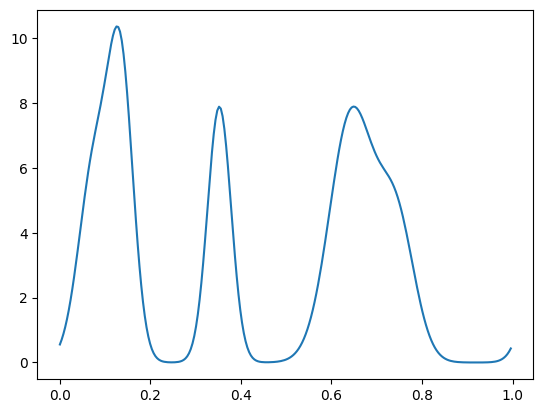

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, data[0])
plt.show()

# 1D Periodic Autoencoder Class

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
torch.set_default_dtype(torch.float64)

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [9]:
class PConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, padding):
        super(PConv1d, self).__init__()

        self.padding = (padding, padding)
        self.conv1d = nn.Conv1d(in_channels, out_channels, 2*padding+1)

    def forward(self, x):
        output = F.pad(x, self.padding, mode = 'circular')
        output = self.conv1d(output)
        return output

In [10]:
class PMaxPool1d(nn.Module):
    def __init__(self, kernel_size):
        super(PMaxPool1d, self).__init__()

        self.kernel_size = kernel_size

    def forward(self, x):
        rolling = torch.stack([F.max_pool1d(torch.roll(x, i, dims = -1), self.kernel_size, self.kernel_size) for i in range(self.kernel_size)])
        shifts = torch.argmax(torch.std(rolling.view(self.kernel_size, x.size(0), -1), dim = -1), dim = 0)
        output = torch.take_along_dim(rolling, shifts.view(1, -1, 1, 1), dim = 0).squeeze(dim = 0)
        return output, shifts

In [11]:
class PBNEncoder(nn.Module):
    def __init__(self, conv_dim, latent_dim):
        super(PBNEncoder, self).__init__()
        self.conv_dim = conv_dim
        self.lin1 = nn.Linear(2*conv_dim, latent_dim)
        self.lin2 = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        shifts = torch.argmax(torch.std(x, dim = 1), dim = -1)
        tmp = shifts[:, None, None].repeat(1, x.shape[1], 1)
        indices = torch.concat([tmp, 1-tmp], dim = -1)
        output = torch.gather(x, -1, indices)
        output = output.view(-1, 2*self.conv_dim)
        output = F.relu(self.lin1(output))
        output = self.lin2(output)
        return output, shifts

In [12]:
class PBNDecoder(nn.Module):
    def __init__(self, conv_dim, latent_dim):
        super(PBNDecoder, self).__init__()
        self.conv_dim = conv_dim
        self.lin1 = nn.Linear(latent_dim, latent_dim)
        self.lin2 = nn.Linear(latent_dim, 2*conv_dim)

    def forward(self, x, shifts):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = output.view(-1, self.conv_dim, 2)
        indices = (torch.arange(output.shape[2])[None, None, :].repeat(1, output.shape[1], 1) + shifts[:, None, None]) % output.shape[2]
        output = torch.gather(output, 2, indices)
        return output

In [13]:
class PUpsample(nn.Module):
    def __init__(self, scale_factor):
        super(PUpsample, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x, shifts):
        w = x.new_zeros(self.scale_factor)
        w[0] = 1
        output = F.conv_transpose1d(x, w.expand(x.size(1), 1, self.scale_factor), stride = self.scale_factor, groups = x.size(1))
        indices = (torch.arange(output.shape[2])[None, None, :].repeat(1, output.shape[1], 1) + shifts[:, None, None]) % output.shape[2]
        output = torch.gather(output, 2, indices)
        return output

In [14]:
class PEncoder(nn.Module):
    def __init__(self, conv_dim, latent_dim):
        super(PEncoder, self).__init__()

        self.cnn = nn.ModuleList([nn.Sequential(PConv1d(1, 1, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(1, 2, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(2, 2, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(2, 4, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(4, 4, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(4, 8, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2)),
                                  nn.Sequential(PConv1d(8, conv_dim, 1),
                                                nn.LeakyReLU(),
                                                PMaxPool1d(2))])
        
        self.bottle_neck = PBNEncoder(conv_dim, latent_dim)
        
    def forward(self, x):
        output = x.view(-1, 1, 256)
        shiftss = []
        for block in self.cnn:
            output, shifts = block(output)
            shiftss.append(shifts)
        output, shifts = self.bottle_neck(output)
        shiftss.append(shifts)
        return output, shiftss

In [15]:
class PDecoder(nn.Module):
    def __init__(self, conv_dim, latent_dim):
        super(PDecoder, self).__init__()
        self.latent_dim = latent_dim

        self.bottle_back = PBNDecoder(conv_dim, latent_dim)
        self.dnn = nn.ModuleList([nn.ModuleList([PUpsample(2),
                                                 PConv1d(conv_dim, 8, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(8, 4, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(4, 4, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(4, 2, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(2, 2, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(2, 1, 1),
                                                 nn.LeakyReLU()]),
                                  nn.ModuleList([PUpsample(2),
                                                 PConv1d(1, 1, 1),
                                                 nn.LeakyReLU()])])

    def forward(self, x, shiftss):
        output = self.bottle_back(x, shiftss[-1])
        for block, shifts in zip(self.dnn, reversed(shiftss[:-1])):
            output = block[0](output, shifts)
            output = block[1](output)
            output = block[2](output)
        return output

In [16]:
class PAE(nn.Module):
    def __init__(self, pencoder, pdecoder):
        super(PAE, self).__init__()
        self.pencoder = pencoder
        self.pdecoder = pdecoder

        self.pencoder.to(device)
        self.pdecoder.to(device)

    def forward(self, x):
        pencoded, shiftss = self.pencoder(x)
        pdecoded = self.pdecoder(pencoded, shiftss)
        return pdecoded

# Trainging Manager Class

In [17]:
from torch.utils.data import DataLoader

class Demo():
    def __init__(self, pae):
        self.network = pae
        self.optim = torch.optim.Adam(self.network.parameters(), lr = 0.001)

    def train(self, loss_fn, epochs, batch_size, dataset):

        def init_weights(module):
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                module.bias.data.fill_(0.01)

        self.network.apply(init_weights)

        loader = DataLoader(dataset, batch_size)

        self.network.to(device)

        epoch_losses = []

        for epoch in range(epochs):
            self.network.train()
            batch_losses = []
            for batch_data in loader:
                batch_data = batch_data.to(device)

                output = self.network(batch_data)
                loss = loss_fn(output, batch_data.view(-1, 1, 256))

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                batch_losses.append(loss.item())

            epoch_losses.append(np.mean(batch_losses))
            print(f'Epoch {epoch + 1}/{epochs}, loss: {np.round(epoch_losses[-1], 4)}', end = '\r')

        plt.figure()
        plt.plot(epoch_losses)
        plt.show()


# Train

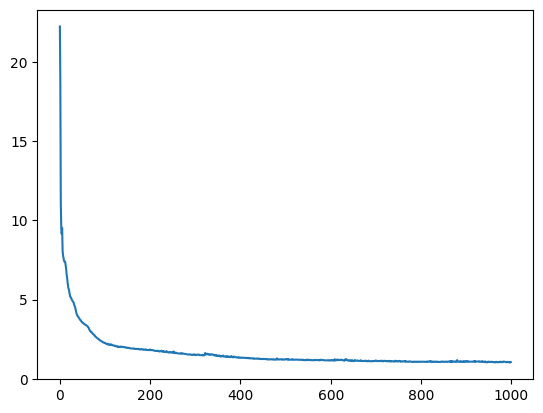

In [18]:
conv_dim = 16
latent_dim = 32

model = Demo(PAE(PEncoder(conv_dim, latent_dim), PDecoder(conv_dim, latent_dim)))

model.train(nn.MSELoss(), 1000, 16, data)

# Check Content-Context

In [19]:
i = 1001
a = torch.from_numpy(data[i:i+1]).view(1, 1, -1)

In [20]:
b = torch.roll(a, 64, dims = -1)

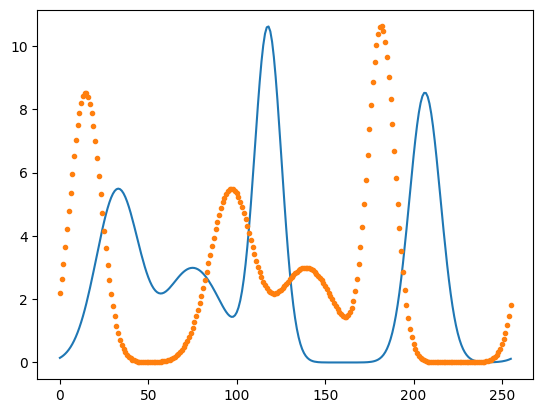

In [21]:
plt.figure()
plt.plot(a[0].detach().numpy().flatten())
plt.plot(b[0].detach().numpy().flatten(), '.')
plt.show()

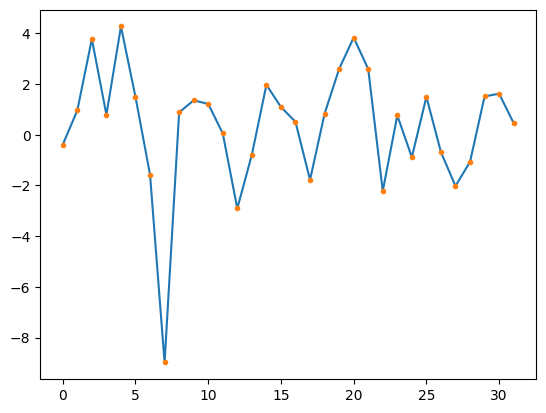

In [22]:
plt.figure() 
plt.plot(model.network.pencoder(a)[0][0].detach().numpy().flatten())
plt.plot(model.network.pencoder(b)[0][0].detach().numpy().flatten(), '.')
plt.show()

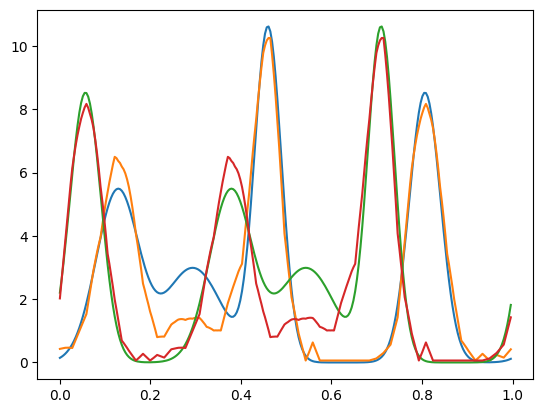

In [23]:
plt.figure() 
plt.plot(x, a[0][0].detach().numpy().flatten())
plt.plot(x, model.network(a)[0][0].detach().numpy().flatten())
plt.plot(x, b[0][0].detach().numpy().flatten())
plt.plot(x, model.network(b)[0][0].detach().numpy().flatten())
plt.show()